# Develop `baynes_sound_agrif` Figure Module

Development of functions for `nowcast.figures.research.baynes_sound_agrif` web site figure module.

**Goal:** A 4 panel figures showing  surface values of
temperature, salinity, diatoms biomass, and nitrate concentration
at 12:30 Pacific time.
Each panel to show all of the Baynes Sound sub-grid as well as
a fringe of the full domain on the 3 non-land sides.
Ideally the axes tick labels will be lon/lat with angled grid lines.

In [51]:
from pathlib import Path
from types import SimpleNamespace

import arrow
import cmocean
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy
from salishsea_tools import viz_tools
import xarray

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_prep_plot_data()` Function

In [3]:
def _prep_plot_data(bs_phys, bs_bio, bs_water_mask, run_date):
    shared.localize_time(bs_phys, time_coord='time_counter')
    shared.localize_time(bs_bio, time_coord='time_counter')
    temperature = _get_data_array(bs_phys.votemper, bs_water_mask, run_date)
    temperature.attrs['long_name'] = 'Conservative Temperature'
    salinity = _get_data_array(bs_phys.vosaline, bs_water_mask, run_date)
    salinity.attrs['long_name'] = 'Reference Salinity'
    return SimpleNamespace(
        temperature=temperature,
        salinity=salinity,
        diatoms=_get_data_array(bs_bio.diatoms, bs_water_mask, run_date),
        nitrate=_get_data_array(bs_bio.nitrate, bs_water_mask, run_date),
    )

In [4]:
def _get_data_array(ds_var, bs_water_mask, run_date):
    exclude_bdy = slice(1, -2)
    return ds_var \
        .isel(deptht=0) \
        .sel(time_counter=run_date.format('YYYY-MM-DD 12:30')) \
        .where(bs_water_mask) \
        .isel(y=exclude_bdy, x=exclude_bdy)

## `_prep_fig_axes()` Function

In [48]:
def _prep_fig_axes(figsize, lons, lats, theme):
    fig, ax = plt.subplots(
        1, 4, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    map_params = SimpleNamespace(
        ll_lon=-68.3, ur_lon=-53.45,
        ll_lat=37.425, ur_lat=49.1,
        lon_0_offset=391.8,
        meridians=numpy.arange(-72, -50, 2),
        parallels=numpy.arange(38, 50, 1),
    )
    central_lon = (
        (map_params.ur_lon - map_params.ll_lon)/2 + map_params.ll_lon 
        + map_params.lon_0_offset
    )
    central_lat = (
        (map_params.ur_lat - map_params.ll_lat)/2 + map_params.ll_lat
    )
    for ax in axs:
        m = Basemap(
            ax=ax_surface, projection='lcc',
            lon_0=central_lon, lat_0=central_lat,
            llcrnrlon=map_params.ll_lon, urcrnrlon=map_params.ur_lon,
            llcrnrlat=map_params.ll_lat, urcrnrlat=map_params.ur_lat,
        )
        # lon/lat grid
        m.drawmeridians(map_params.meridians, labels=(False, False, False, True))
        m.drawparallels(map_params.parallels, labels=(True, False, False, False))
    x, y = m(lons, lats)
    return fig, axs, x, y

## `_plot_surface_fields()` Function

In [19]:
def _plot_surface_fields(axs, plot_data, theme):
    vars = [
        (plot_data.temperature, cmocean.cm.thermal),
        (plot_data.salinity, cmocean.cm.haline),
        (plot_data.diatoms, cmocean.cm.algae),
        (plot_data.nitrate, cmocean.cm.matter),
    ]
    for i, (var, cmap) in enumerate(vars):
        _plot_surface_field(axs[i], var, cmap, theme)

In [46]:
def _plot_surface_field(ax, var, cmap, theme):
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('burlywood')
    contour_set = ax.contourf(
        var, cmap=cmap,
        levels=numpy.linspace(
            numpy.floor(var.where(var>0).min()),
            numpy.floor(var.where(var>0).max()),
            20
        ),
        extend='max',
    )
    cbar = plt.colorbar(contour_set, ax=ax)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        f'{var.attrs["long_name"]} [{var.attrs["units"]}]',
        color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'],
    )
    viz_tools.set_aspect(ax)
    ax.set_title('')
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [42]:
def make_figure(
    bs_phys, bs_bio, bs_water_mask, run_date, lons, lats,
    figsize=(18, 9),
    theme=nowcast.figures.website_theme):
    plot_data = _prep_plot_data(bs_phys, bs_bio, bs_water_mask, run_date)
    fig, axs = _prep_fig_axes(figsize, lons, lats, theme)
    _plot_surface_fields(axs, plot_data, theme)
#     _plot_water_level_time_series(ax, place, plot_data, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


1.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


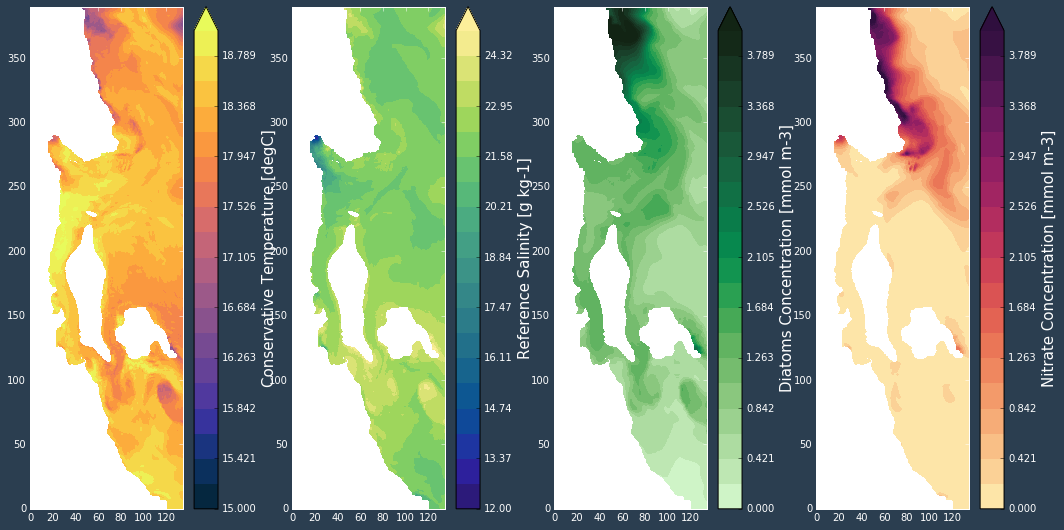

In [47]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
reload(website_theme)

results_archive = Path('/results/SalishSea/nowcast-agrif/')
run_date = arrow.get('2018-06-28')
ddmmmyy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

bs_phys = xarray.open_dataset(
    results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc')
bs_bio = xarray.open_dataset(
    results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc')
bathy = xarray.open_dataset(
    '/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc')
bs_water_mask = bathy.Bathymetry!=0

fig = make_figure(bs_phys, bs_bio, bs_water_mask, run_date, bathy.nav_lon.values, bathy.nav_lat.values)

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


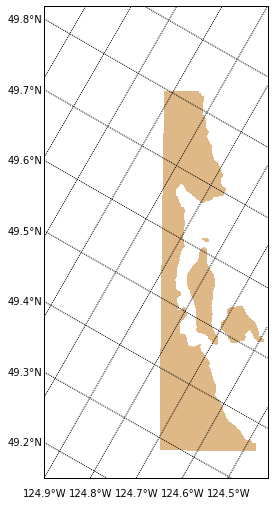

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(4, 12))
map_params = SimpleNamespace(
    ll_lon=-124.9, ur_lon=-125,
    ll_lat=49.15, ur_lat=50,
    lon_0_offset=39,
    meridians=numpy.arange(-125.5, -122, 0.1),
    parallels=numpy.arange(48, 51, 0.1),
)
central_lon = (
    (map_params.ur_lon - map_params.ll_lon)/2 + map_params.ll_lon 
    + map_params.lon_0_offset
)
central_lat = (
    (map_params.ur_lat - map_params.ll_lat)/2 + map_params.ll_lat
)
m = Basemap(
    ax=ax, projection='lcc',
    lon_0=central_lon, lat_0=central_lat,
    llcrnrlon=map_params.ll_lon, urcrnrlon=map_params.ur_lon,
    llcrnrlat=map_params.ll_lat, urcrnrlat=map_params.ur_lat,
)
# lon/lat grid
m.drawmeridians(map_params.meridians, labels=(False, False, False, True))
m.drawparallels(map_params.parallels, labels=(True, False, False, False))

grid = xarray.open_dataset(
    '/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc',
    mask_and_scale=False,
)
x, y = m(grid.nav_lon.values, grid.nav_lat.values)
ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
# ax.contour(x, y, grid.Bathymetry, [-0.01, 0.01], colors='black')


In [39]:
results_archive = Path('/results/SalishSea/nowcast-agrif/')
run_date = arrow.get('2018-05-25')
ddmmmyy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

In [5]:
bs_phys = xarray.open_dataset(results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc')
bs_phys

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 139, y: 394)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.50001 3.50003 4.50007 ...
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float64 ...
    time_centered_bounds  (time_counter, axis_nbounds) float64 ...
    time_counter_bounds   (time_counter, axis_nbounds) float64 ...
    votemper              (time_counter, deptht, y, x) float64 ...
    vosal

In [6]:
bs_bio = xarray.open_dataset(results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc')
bs_bio

<xarray.Dataset>
Dimensions:                       (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 139, y: 394)
Coordinates:
    nav_lat                       (y, x) float32 ...
    nav_lon                       (y, x) float32 ...
  * deptht                        (deptht) float32 0.5 1.5 2.50001 3.50003 ...
    time_centered                 (time_counter) datetime64[ns] ...
  * time_counter                  (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon                    (y, x, nvertex) float32 ...
    bounds_lat                    (y, x, nvertex) float32 ...
    area                          (y, x) float32 ...
    deptht_bounds                 (deptht, axis_nbounds) float32 ...
    nitrate                       (time_counter, deptht, y, x) float64 ...
    time_centered_bounds          (time_counter, axis_nbounds) float64 ...
    time_counter_bounds           (time_counter

In [8]:
mesh_mask = xarray.open_dataset('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/mesh_mask201702.nc')
mesh_mask

<xarray.Dataset>
Dimensions:  (x: 139, y: 394)
Dimensions without coordinates: x, y
Data variables:
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    mbathy   (y, x) float32 ...

In [9]:
mesh_mask.mbathy

<xarray.DataArray 'mbathy' (y: 394, x: 139)>
array([[  0.,   0.,   0., ...,  20.,  24.,  24.],
       [  0.,   0.,   0., ...,  20.,  24.,  24.],
       [  0.,   0.,   0., ...,  24.,  26.,  26.],
       ..., 
       [  0.,   0.,   0., ...,  34.,  34.,  34.],
       [  0.,   0.,   0., ...,  34.,  34.,  34.],
       [  0.,   0.,   0., ...,  34.,  34.,  34.]], dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    units:      count
    long_name:  fortran index of deepest water cell, T-grid

In [10]:
water = mesh_mask.mbathy!=0
water

<xarray.DataArray 'mbathy' (y: 394, x: 139)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)
Dimensions without coordinates: y, x

In [21]:
bathy = xarray.open_dataset('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc')
bathy

<xarray.Dataset>
Dimensions:     (x: 139, y: 394)
Dimensions without coordinates: x, y
Data variables:
    Bathymetry  (y, x) float32 ...
    nav_lat     (y, x) float32 ...
    nav_lon     (y, x) float32 ...
Attributes:
    history:  Tue Oct 17 16:59:44 2017: ncks -4 -L4 -O subgrids/BaynesSound/b...
    NCO:      "4.6.3"

In [22]:
bathy.Bathymetry

<xarray.DataArray 'Bathymetry' (y: 394, x: 139)>
array([[   0.      ,    0.      ,    0.      , ...,   69.899307,   79.677513,
          81.5     ],
       [   0.      ,    0.      ,    0.      , ...,   70.181717,   82.107498,
          83.322487],
       [   0.      ,    0.      ,    0.      , ...,   79.272141,   86.967468,
          86.967468],
       ..., 
       [   0.      ,    0.      ,    0.      , ...,  272.456726,  269.081726,
         269.081726],
       [   0.      ,    0.      ,    0.      , ...,  266.495209,  264.16507 ,
         264.16507 ],
       [   0.      ,    0.      ,    0.      , ...,  266.495209,  263.      ,
         263.      ]], dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    units:      metres
    long_name:  sea_floor_depth

In [23]:
water = bathy.Bathymetry!=0
water

<xarray.DataArray 'Bathymetry' (y: 394, x: 139)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)
Dimensions without coordinates: y, x

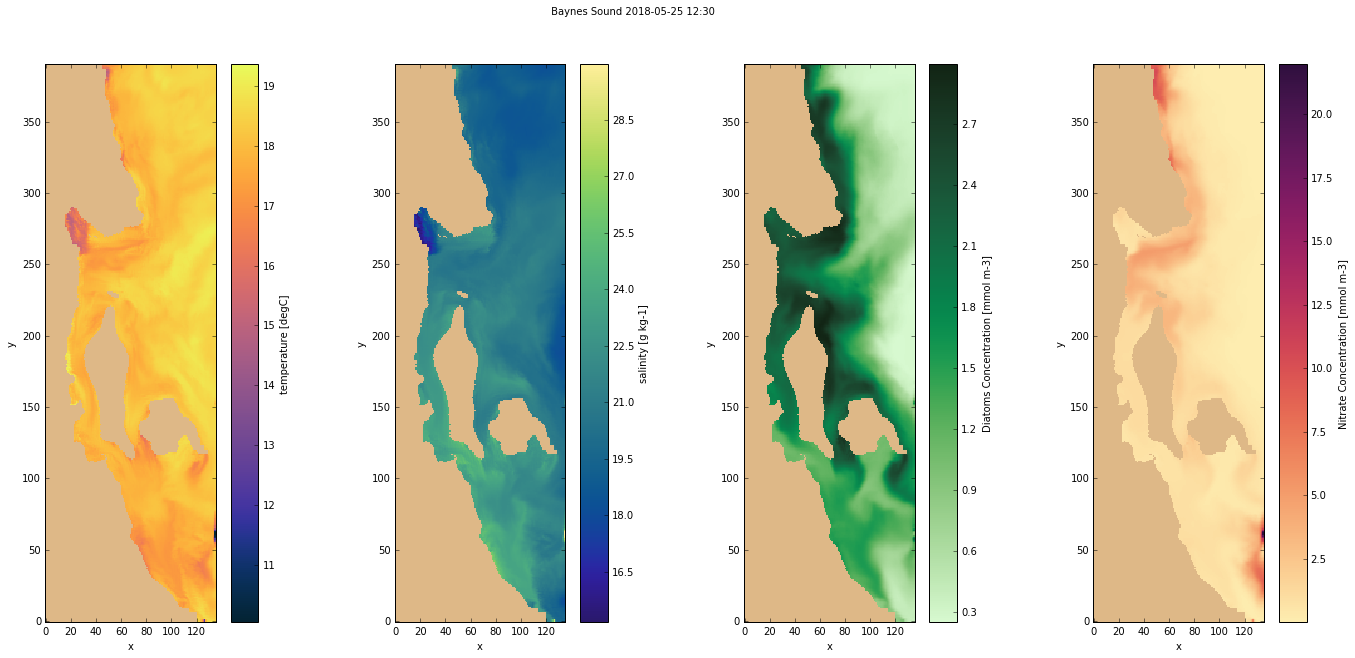

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(24, 10))
exclude_bdy = slice(1, -2)
vars = [
    {
        'dataset': bs_phys,
        'nemo var': 'votemper',
        'cmap': cmocean.cm.thermal,
    },
    {
        'dataset': bs_phys,
        'nemo var': 'vosaline',
        'cmap': cmocean.cm.haline,
    },
    {
        'dataset': bs_bio,
        'nemo var': 'diatoms',
        'cmap': cmocean.cm.algae,
    },
    {
        'dataset': bs_bio,
        'nemo var': 'nitrate',
        'cmap': cmocean.cm.matter,
    }
]
for i, var in enumerate(vars):
    cmap = plt.get_cmap(var['cmap'])
    cmap.set_bad('burlywood')
    ds_var = getattr(var['dataset'], var['nemo var'])
    mesh = ds_var.isel(deptht=0, time_counter=12) \
        .where(water) \
        .isel(y=exclude_bdy, x=exclude_bdy).plot(
            ax=axs[i], cmap=cmap,
    )
    mesh.colorbar.set_label(f'{ds_var.attrs["long_name"]} [{ds_var.attrs["units"]}]')
for ax in axs:
    viz_tools.set_aspect(ax)
    ax.set_title('')
fig.suptitle(f'Baynes Sound {bs_phys.time_counter.dt.year.values[0]}-{bs_phys.time_counter.dt.month.values[0]:02d}-{bs_phys.time_counter.dt.day.values[0]:02d} 12:30')

In [28]:
bs_phys.votemper

<xarray.DataArray 'votemper' (time_counter: 24, deptht: 40, y: 394, x: 139)>
[52575360 values with dtype=float64]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  20 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 20 s)
    cell_measures:       area: area

In [2]:
ds = xarray.open_dataset(
    '/results/SalishSea/nowcast-agrif/25may18/1_SalishSea_1h_20180525_20180525_grid_T.nc')
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 139, y: 394)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.50001 3.50003 4.50007 ...
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float64 ...
    time_centered_bounds  (time_counter, axis_nbounds) float64 ...
    time_counter_bounds   (time_counter, axis_nbounds) float64 ...
    votemper              (time_counter, deptht, y, x) float64 ...
    vosal

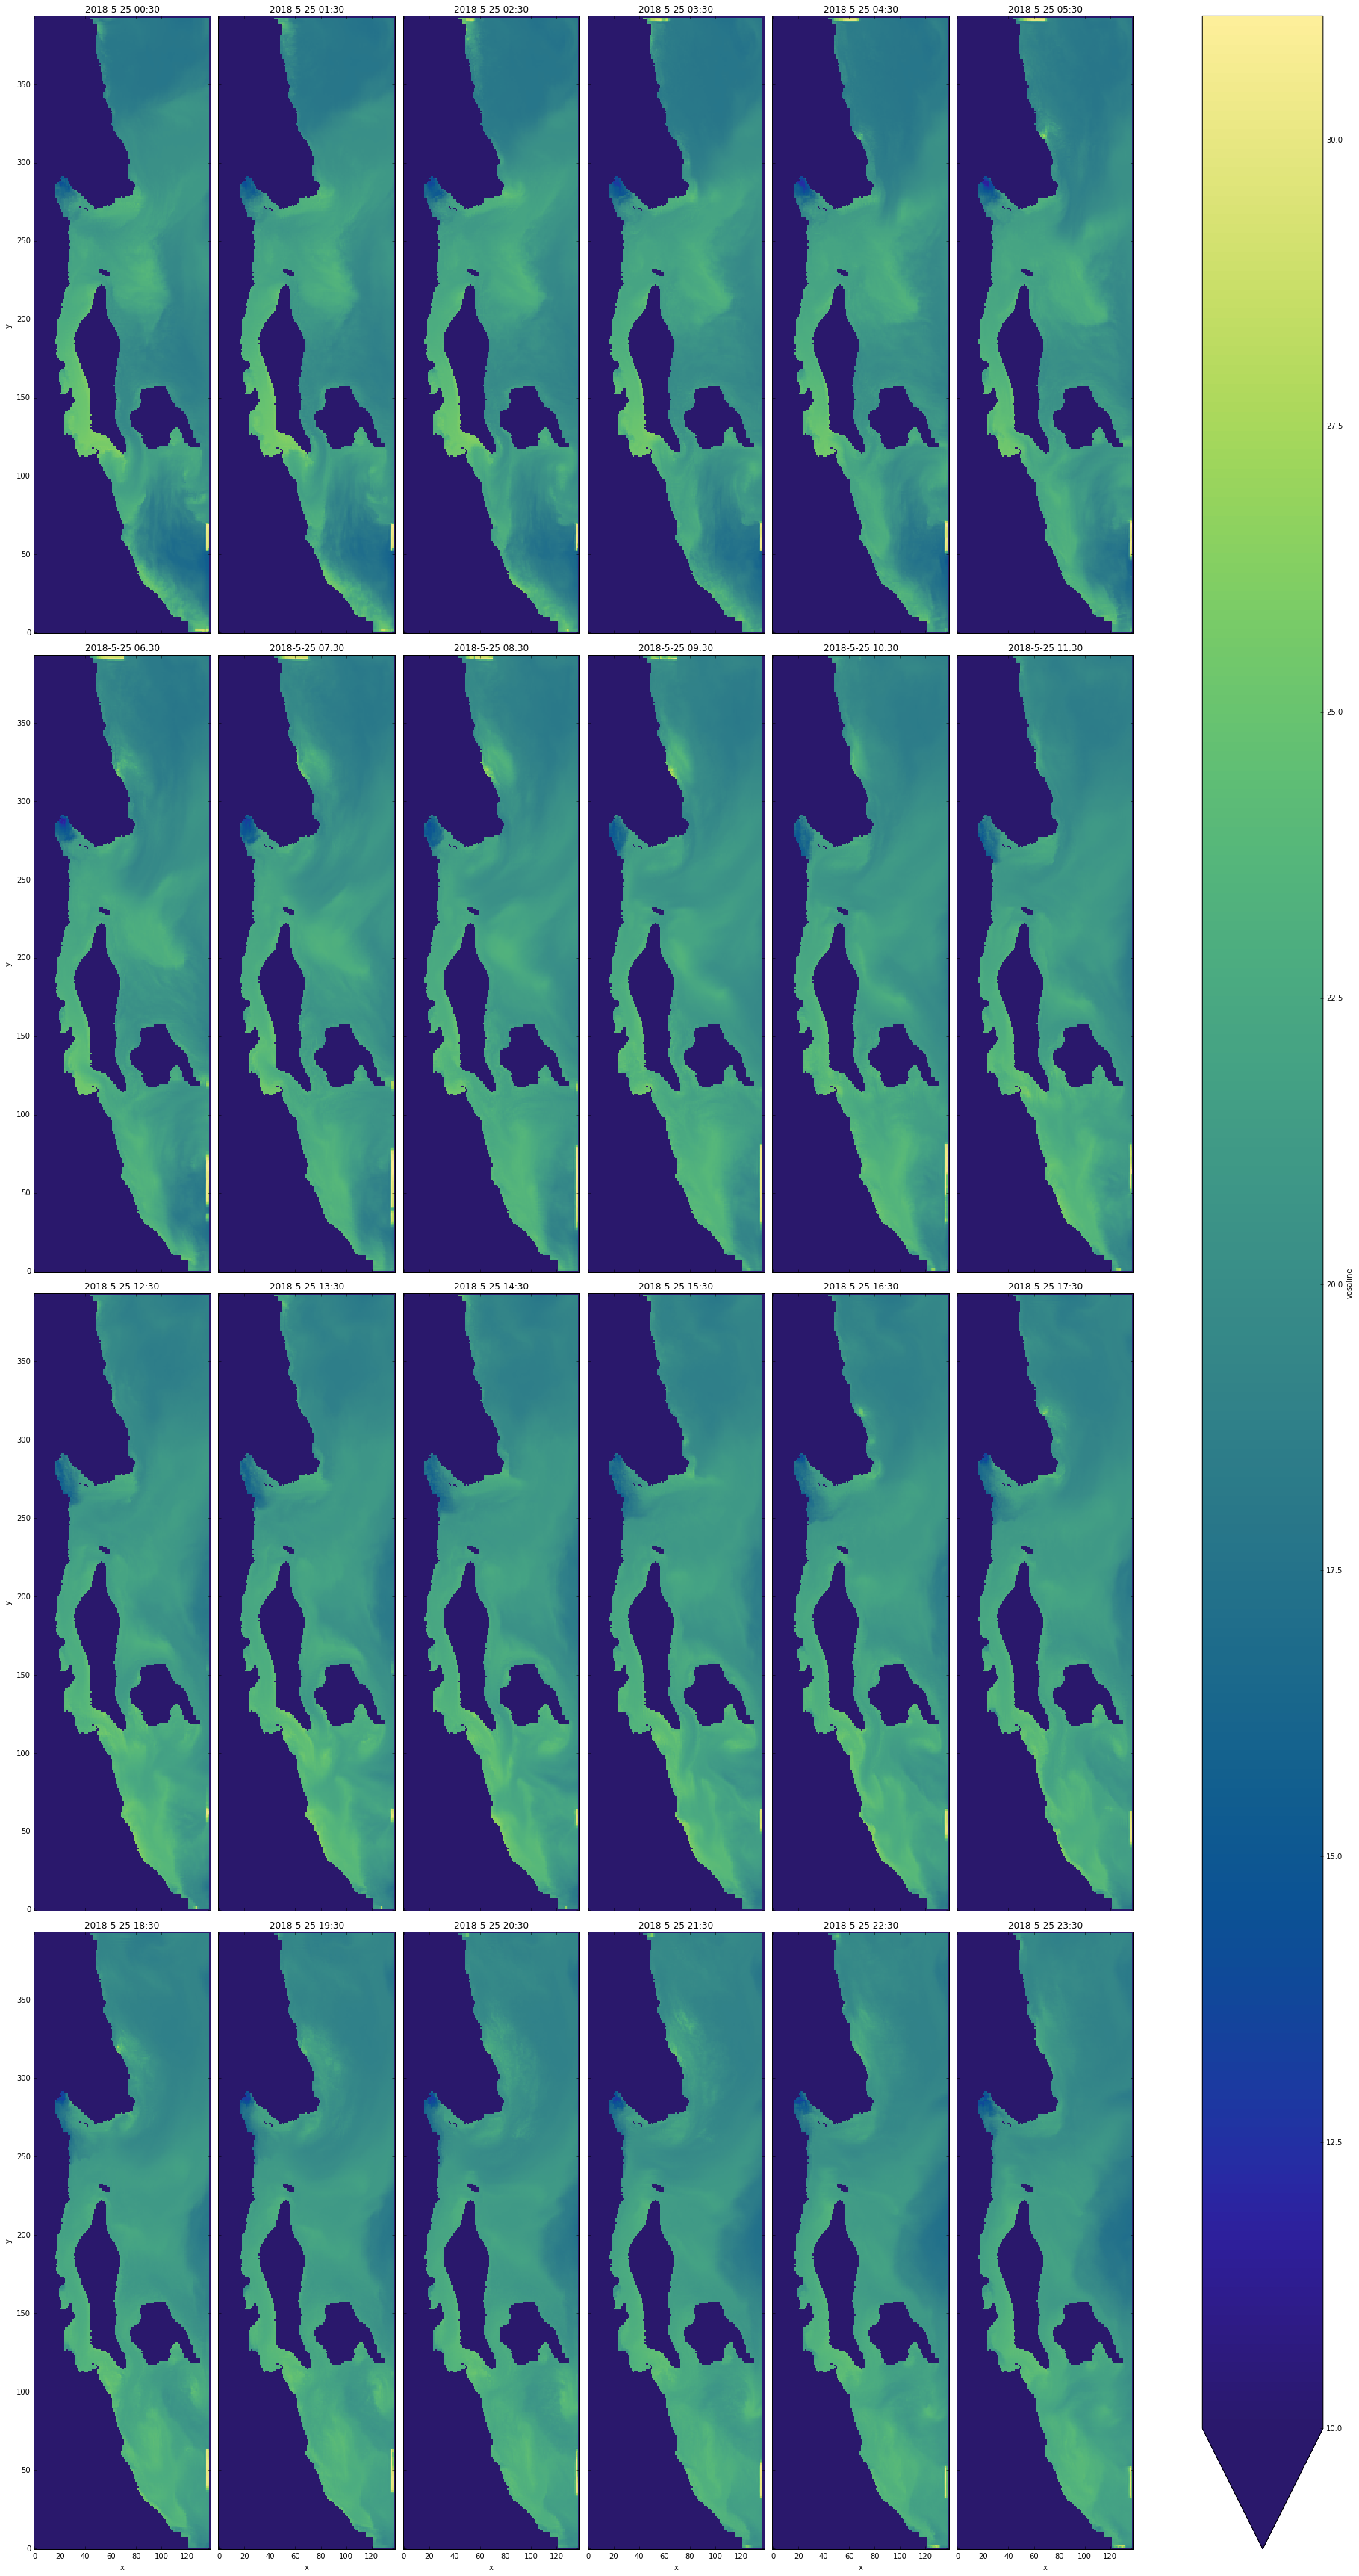

In [43]:
fg = ds.vosaline.isel(deptht=0).plot(
    x='x', y='y', col='time_counter', col_wrap=6, 
    aspect=139/394, size=12,
    cmap=cmocean.cm.haline, vmin=10,
)
date = f'{ds.time_counter.dt.year.values[0]}-{ds.time_counter.dt.month.values[0]}-{ds.time_counter.dt.day.values[0]}'
for i, ax in enumerate(fg.axes.flat):
    ax.set_title(f'{date} {ds.time_counter.dt.hour.values[i]:02d}:30')

In [16]:
ds.vosaline.max(), ds.vosaline.min()

(<xarray.DataArray 'vosaline' ()>
 array(31.651756286621094), <xarray.DataArray 'vosaline' ()>
 array(0.0))